In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, normalized_mutual_info_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import  DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif

from scipy import stats
from scipy.stats import chi2_contingency

# **1. Data Preprocessing**

In [3]:
# https://www.kaggle.com/datasets/alexteboul/diabetes-health-indicators-dataset?select=diabetes_012_health_indicators_BRFSS2015.csv

df = pd.read_csv('Data/diabetes-indicators-balanced-5050split.csv')
df.head(2)

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0


In [4]:
# For simplification
df.rename(columns={'Diabetes_binary': 'Diabetes'}, inplace=True)

# for better memory usage and interpretability, change the dtypes
bol_columns = ["Diabetes","HighBP","HighChol", 
                "CholCheck", "Smoker",  "Stroke",  "HeartDiseaseorAttack",
                "PhysActivity",  "Fruits",  "Veggies",  "HvyAlcoholConsump",  
                "AnyHealthcare",  "NoDocbcCost",  "DiffWalk",  "Sex"]

cat_columns = [ "GenHlth","MentHlth","PhysHlth",
               "Age","Education","Income"]

# Binary -> boolean
for column in bol_columns:
    df[column] = df[column].astype(bool)

# Categorical -> int32
for column in cat_columns:
    df[column] = df[column].astype("int32")

# Continous -> float32
df['BMI'] = df['BMI'].astype("float32")


# Information of features
display(df.info())

# Memory usage before 11.9 mb
# Memory usage after 2.9 mb
# 75% reduction in memory usage

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes              70692 non-null  bool   
 1   HighBP                70692 non-null  bool   
 2   HighChol              70692 non-null  bool   
 3   CholCheck             70692 non-null  bool   
 4   BMI                   70692 non-null  float32
 5   Smoker                70692 non-null  bool   
 6   Stroke                70692 non-null  bool   
 7   HeartDiseaseorAttack  70692 non-null  bool   
 8   PhysActivity          70692 non-null  bool   
 9   Fruits                70692 non-null  bool   
 10  Veggies               70692 non-null  bool   
 11  HvyAlcoholConsump     70692 non-null  bool   
 12  AnyHealthcare         70692 non-null  bool   
 13  NoDocbcCost           70692 non-null  bool   
 14  GenHlth               70692 non-null  int32  
 15  MentHlth           

None

In [5]:
print("before:",df.shape)
# Search for duplicated instances and drop
print("Duplications:",df.duplicated().sum())
#display(df.loc[df.duplicated(),:].head())
df.drop_duplicates(inplace=True)
print('After:',df.shape)

before: (70692, 22)
Duplications: 1635
After: (69057, 22)


Let's check if there are zeros in the categorical features where the range is above zero. This can be interpreted as missing values, so we need to change then to NaN.

In [6]:
for column in cat_columns:
    print('Missing Values:', f'{round(100*df[column].eq(0).sum()/df.shape[0], 2)} %', f'in {column}')

print(f"Missing Values: {df['BMI'].eq(0).sum()} % in BMI")

Missing Values: 0.0 % in GenHlth
Missing Values: 67.31 % in MentHlth
Missing Values: 55.48 % in PhysHlth
Missing Values: 0.0 % in Age
Missing Values: 0.0 % in Education
Missing Values: 0.0 % in Income
Missing Values: 0 % in BMI


There are indeed missing values for `MentHlth` and `PhysHlth`, both must have a range between 1-30. But because the missing values account for 67% of my dataset, it's concerning. Even if this feature correlate  highly with the target, removing 67% of data might be worse. A straightforward solution could be to just drop these features.


In [7]:
#missing_values = ['MentHlth', 'PhysHlth']
#for column in missing_values:
#    df[column] = df[column].replace(0, np.nan)

#missing_data = df.isna().sum()
#display(missing_data[missing_data > 0 ]) 
#display(df.head(2))

df.drop(columns=['MentHlth', 'PhysHlth'], inplace=True)

## **1.1 Split Dataset**

In [8]:
# Split in 60% Train /20% Validation/ 20% Test
df_train_large, df_test = train_test_split(df, test_size = 0.2, random_state = 1)
df_train, df_val = train_test_split(df_train_large, train_size = 0.75, random_state = 1)

# Save target feature
Y_train_large = df_train_large['Diabetes'].values
Y_test = df_test['Diabetes'].values
Y_train = df_train['Diabetes'].values
Y_val = df_val['Diabetes'].values

# Drop target feature 
#df_train_large.drop('Diabetes', axis=1, inplace=True)
df_train.drop('Diabetes', axis=1, inplace=True)
df_val.drop('Diabetes', axis=1, inplace=True)
df_test.drop('Diabetes', axis=1, inplace=True)

# **2. Exploratory Data Analysis (EDA)**

Let's proceed with the EDA in the `df_train_large` dataset, which is the combination of both training and validation sets. To prevent data leakage, we don't include the test set for the EDA. This will ensure  the trained model evaluation on the test set is unbiased, without information from the train set mistakenly leakage to the test.


## **2.1 Feature Distribution**

In [9]:
# Create a dataset without the target feature
df_train_dropped = df_train_large.drop('Diabetes', axis=1)

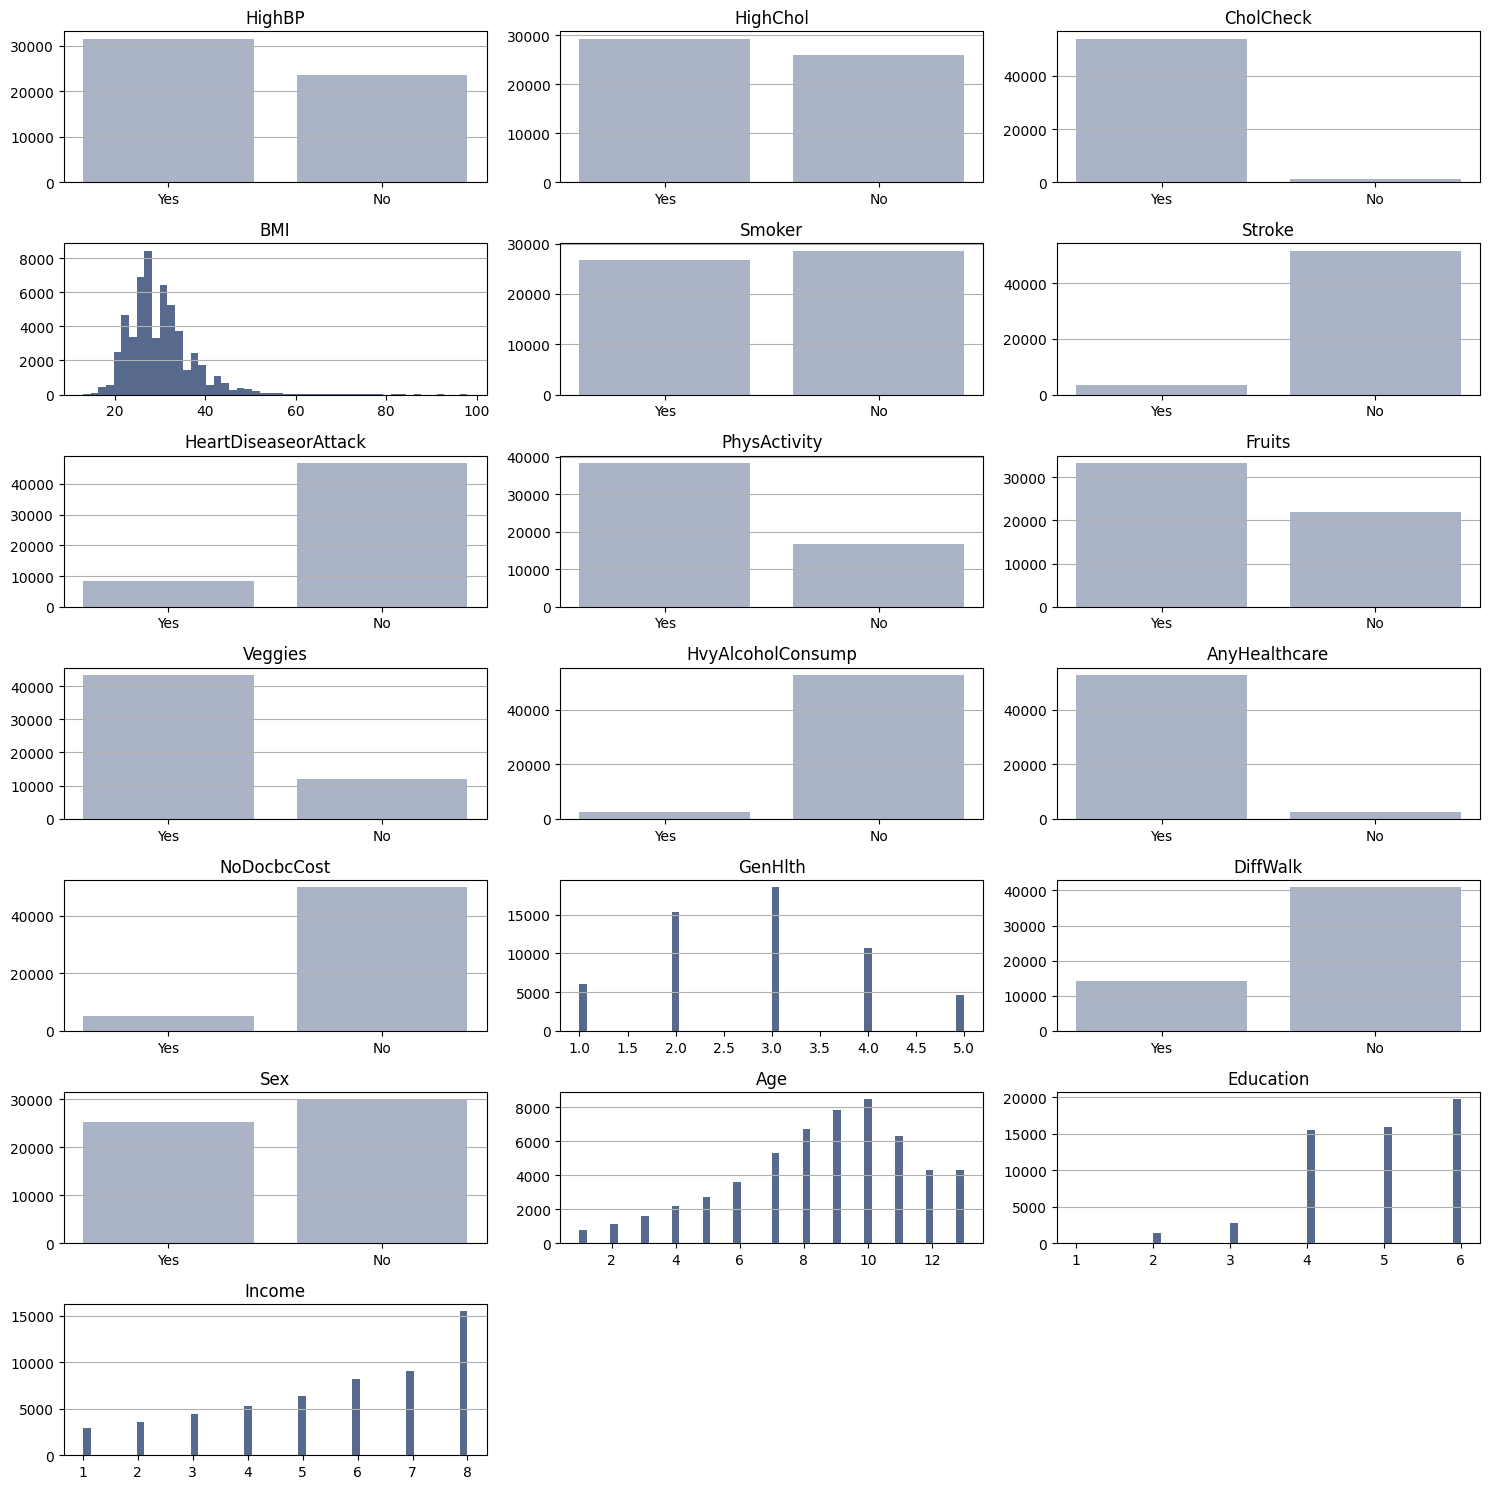

In [10]:
features = df_train_dropped.columns
n_features = len(features)

fig, axes = plt.subplots(nrows = 7, ncols=3, figsize=(15, 15))

for idx, feature in enumerate(features):
    # Identify row and column in the grid
    row, col = divmod(idx, 3)
    
    # Check if the feature is boolean type
    if np.issubdtype(df_train_dropped[feature].dtype, np.bool_):
        Yes_count = np.sum(df_train_large[feature])
        No_count = len(df_train_large[feature]) - Yes_count
        axes[row, col].bar(['Yes', 'No'], [Yes_count, No_count], color='#2D4471', alpha = 0.4)
    else:
        # Plot histogram for the current feature
        axes[row, col].hist(df_train_dropped[feature], bins=50, color='#2D4471', alpha = 0.8,)

    axes[row, col].set_title(feature)
    axes[row, col].grid(axis='y')

# remove empty plots
for ax in axes.ravel()[len(features):]:
    ax.axis('off')

# Adjust layout
plt.tight_layout()
plt.show()

It's appear that has outliers at BMI that wee need to take a closer look.

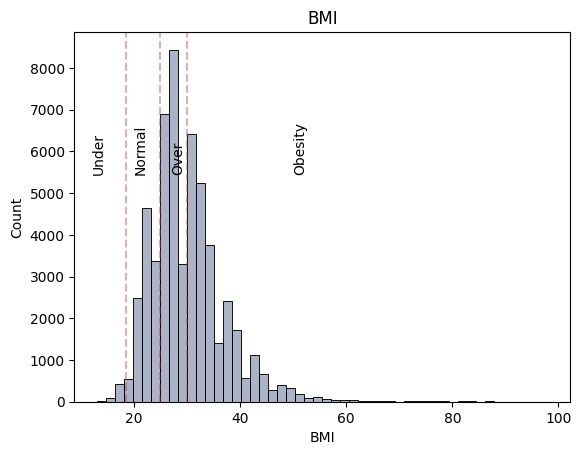

In [11]:
# From World Health Organization (WHO):
#---------------------------
# Under: BMI less than 18.5
# Normal: BMI between 18.5 and 24.9
# Over: BMI between 25 and 29.9
# Obesity: BMI of 30 or greater

plt.axvline(18.5, color='#BE3232', linestyle='--', alpha = 0.4)
plt.axvline(24.9, color='#BE3232', linestyle='--', alpha = 0.4)
plt.axvline(29.9, color='#BE3232', linestyle='--', alpha = 0.4)

# add text
plt.text(12, 5500, 'Under', rotation=90, size=10)
plt.text(20, 5500, 'Normal', rotation=90, size=10)
plt.text(27, 5500, 'Over', rotation=90, size=10)
plt.text(50, 5500, 'Obesity', rotation=90, size=10)

sns.histplot(df_train_dropped['BMI'], bins=50, alpha=0.4, color='#2D4471')

plt.title('BMI')
plt.show()

## **2.2 Feature Importance**

In [12]:
def plot_correlation(correlation_data, title="Correlation", 
                     y_label="Correlation Value", feature_name="Feature"):

    plt.figure(figsize=(15, 7))
    correlation_data.plot(kind='bar', color='#2D4471', alpha=0.5)
    plt.ylabel(y_label)
    plt.xlabel('Features')
    plt.title(title)
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

**Mutual Information**

Given that most of our features are binary, having only one numerical feature  for `BMI`, a first natural choice of metric to account correlation would be the Mutual information (MI). MI accounts for linear and non-linear relation, is robust against outliers and can be reliable for any numerical or categorical features.  

Let's compare the MI of the features with the target variable `Diabetes`.

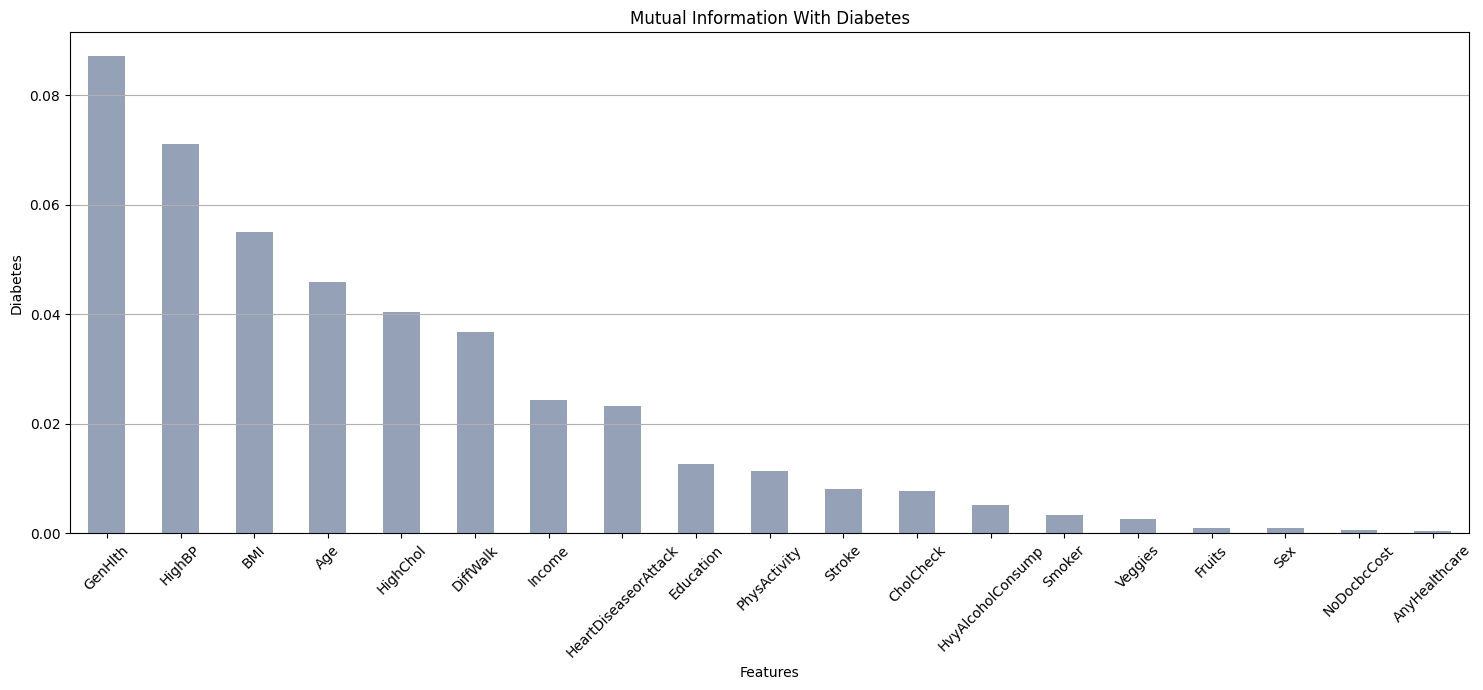

Best correlated features:
 ['GenHlth', 'HighBP', 'BMI', 'Age', 'HighChol', 'DiffWalk', 'Income', 'HeartDiseaseorAttack']


In [13]:
mi_values = mutual_info_classif(df_train_dropped, Y_train_large, discrete_features=True)

mi_column = pd.DataFrame(mi_values, index=df_train_dropped.columns, 
                         columns=['Diabetes_MI']).sort_values(by='Diabetes_MI', ascending=False)

plot_correlation(mi_column['Diabetes_MI'], title = "Mutual Information With Diabetes", 
                 y_label="Diabetes", feature_name = "Feature")


# Select features with MI > 0.02
best_mi_features = list(mi_column[mi_column['Diabetes_MI'] > 0.020].index)
print("Best correlated features:\n",best_mi_features)

The features `GenHlth`, `HighBP`, `BMI`, `Age`, `HighChol`,  `DiffWalk`, `PhysHlth`, `Income`, `HeartDiseaseorAttack` related to the target variable `Diabetes` preset the most significant entropy reduction.

**Spearman Correlation**

Some of our features, like `GenHlth`, `MentHlth`, `PhysHlth`, `Age`, `Education`, `Income` are ordinal, which means that they follow a order. A useful metric for this case is Spearman Correlation. Spearman Correlation is a non-parametric metric (does not assume any specific distribution for the data) and are more reliable to ordinal data. It captures monotonic relationships, whether linear or not.

Let's compare the Spearman Correlation of the features with the target variable `Diabetes`.

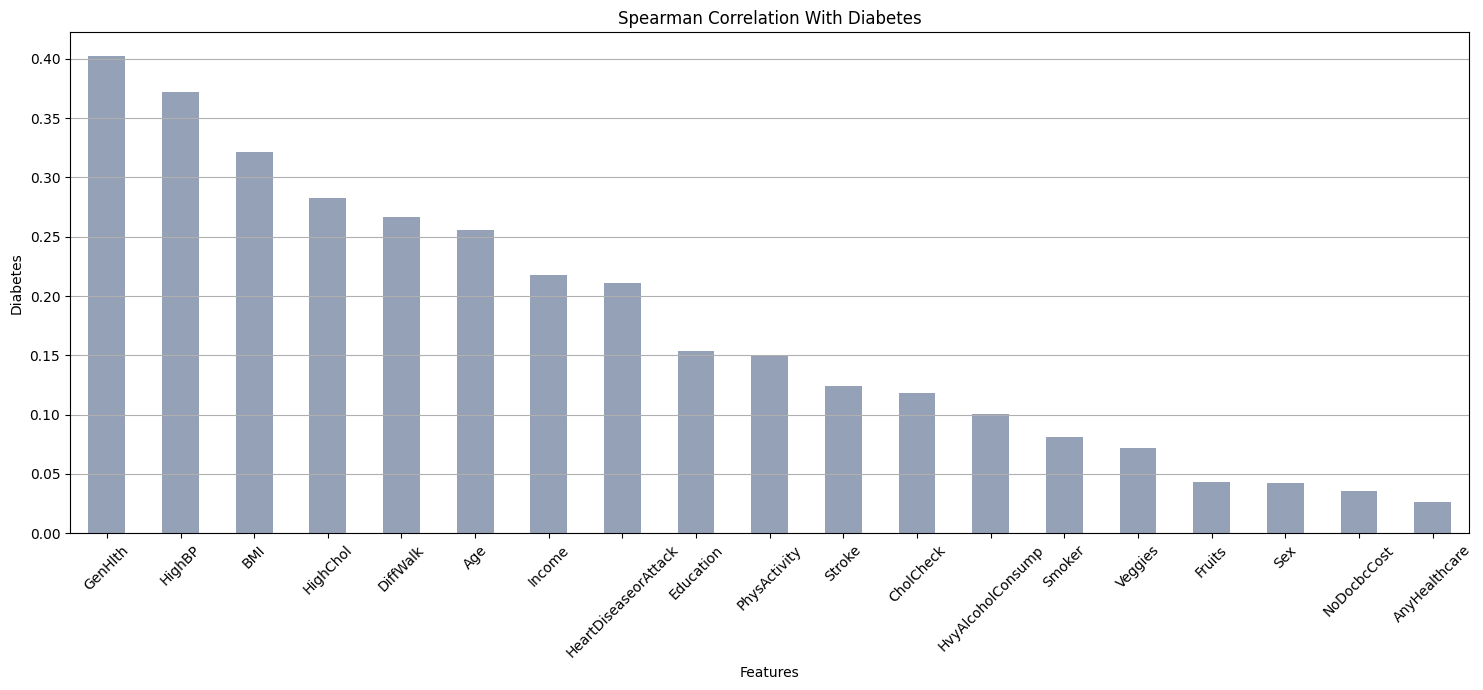

Best correlated features:
 ['GenHlth', 'HighBP', 'BMI', 'HighChol', 'DiffWalk', 'Age', 'Income', 'HeartDiseaseorAttack', 'Education', 'PhysActivity']


In [14]:
# Calculate Spearman correlation
spearman_corr = df_train_large.corr(method='spearman')['Diabetes'].agg(np.abs)\
                                                .sort_values(ascending=False)\
                                                .drop('Diabetes')

plot_correlation(spearman_corr, title="Spearman Correlation With Diabetes", 
                 y_label="Diabetes", feature_name="Feature")


# Select features with MI > 0.02
best_spearman_features = list(spearman_corr[spearman_corr > 0.14].index.tolist())
print("Best correlated features:\n",best_spearman_features)

Let's check one more metric, Pearson correlation. While Spearman detects monotonic relationships, Pearson captures linear relationships.

**Pearson Correlation** 

The Pearson correlation accounts only for linear relationships and is very sensitive to outliers. It's not particularly reliable for categorical data, especially binary ones.

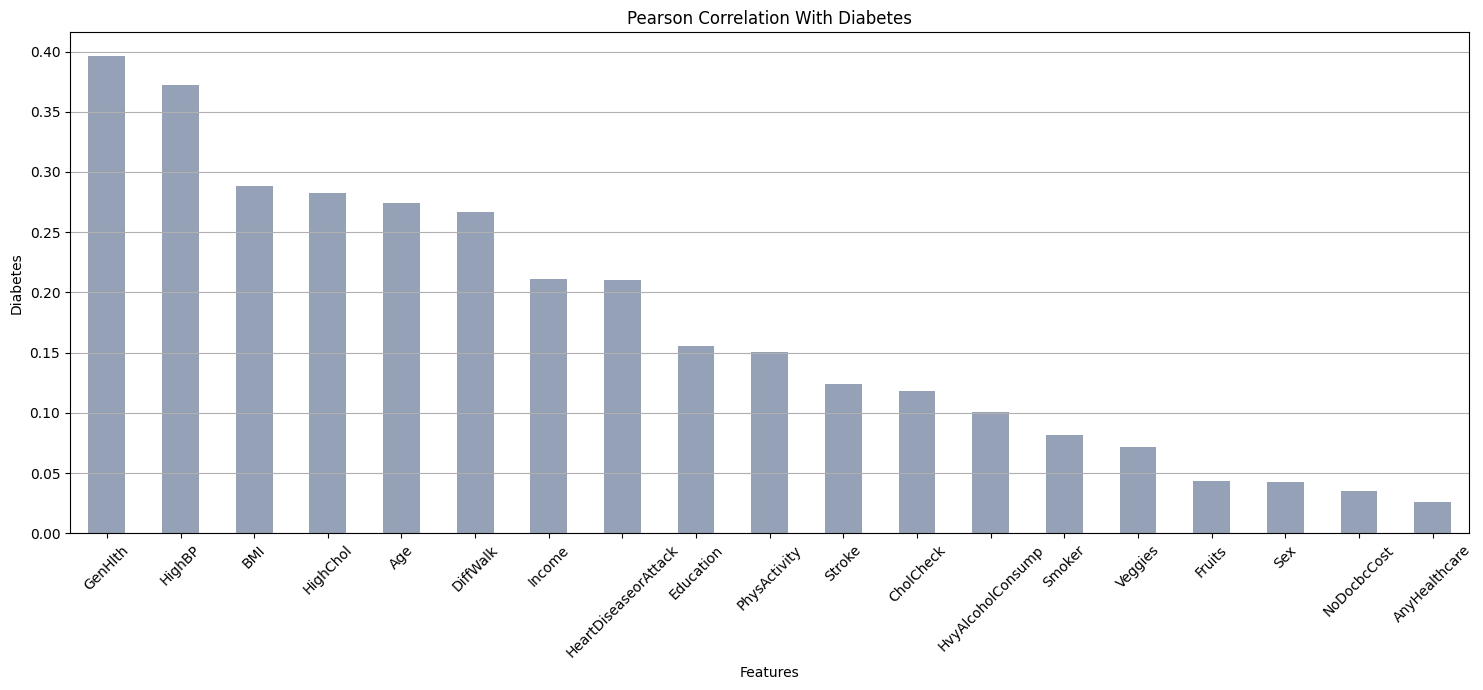

Best correlated features:
 ['GenHlth', 'HighBP', 'BMI', 'HighChol', 'Age', 'DiffWalk', 'Income', 'HeartDiseaseorAttack', 'Education', 'PhysActivity']


In [15]:
# Calculate Pearson correlation
pearson_corr = df_train_large.corr(method='pearson')['Diabetes'].agg(np.abs)\
                                                .sort_values(ascending=False)\
                                                .drop('Diabetes')

# Plot the correlation
plot_correlation(pearson_corr, title="Pearson Correlation With Diabetes",
                 y_label="Diabetes", feature_name="Feature")

# Select features with correlation value > 0.14
best_pearson_features = pearson_corr[pearson_corr > 0.14].index.tolist()
print("Best correlated features:\n", best_pearson_features)

Utilizing three distinct metrics — Mutual Information (MI), Pearson, and Spearman — I constructed a schematic representation of a diagram that illustrates the shared and unique characteristics of each metric.

The diagram can provide a better view of how these metrics intersect and which features emerge as a relevant correlation with the target variable.

<center><img src = "Images/metrics-venn-diagram.png" width="400" height="400"/></center>

Using this idea, let take the overlapping sets of features selected by each metric.

In [16]:
mi_set = set(best_mi_features)
pearson_set = set(best_pearson_features)
spearman_set = set(best_spearman_features)

# Common features across pearson and mutual information
pearson_mi = (pearson_set.intersection(mi_set))
print("\n Pearson and MI intersection:\n",pearson_mi)

# Common features across spearman and mutual information
spearman_mi = (spearman_set.intersection(mi_set))
print("\n Spearman and MI intersection:\n",spearman_mi)

# Common features across spearman and pearson
spearman_pearson = (spearman_set.intersection(pearson_set))
print("\n Spearman and Pearson intersection:\n",spearman_pearson)

# Common features across all three metrics
intersection_all = mi_set.intersection(pearson_set).intersection(spearman_set)
print("\nIntersection for all metrics:\n",intersection_all)


 Pearson and MI intersection:
 {'HighBP', 'GenHlth', 'Income', 'HighChol', 'DiffWalk', 'Age', 'HeartDiseaseorAttack', 'BMI'}

 Spearman and MI intersection:
 {'HighBP', 'GenHlth', 'Income', 'HighChol', 'DiffWalk', 'Age', 'HeartDiseaseorAttack', 'BMI'}

 Spearman and Pearson intersection:
 {'HighBP', 'GenHlth', 'Income', 'HighChol', 'PhysActivity', 'Education', 'DiffWalk', 'Age', 'HeartDiseaseorAttack', 'BMI'}

Intersection for all metrics:
 {'HighBP', 'GenHlth', 'Income', 'HighChol', 'DiffWalk', 'Age', 'HeartDiseaseorAttack', 'BMI'}


From this analyze for the correlations we can conclude that the features `HighChol`, `DiffWalk`, `GenHlth`, `HighBP`, `BMI`, `Age`, `Income`, `HeartDiseaseorAttack` appear to have a higher degree of relevance compare to the target `Diabetes`. All three metrics show a agreement for the relevance of these features. 

Now, with a more restricted set of features, it's essential to closely examine the relationship between the each feature and the target variable based on their frequency. To do this, we can create a frequency table and illustrate the results using a bar plot. 

Let's take the set with the common feature across all three metrics to proceed with the analyze.

In [150]:
# Separate in binary and non binary
numerical = ['BMI']
categorical = ['GenHlth', 'Age', 'Income']
binary = ['HighChol','DiffWalk', 'HighBP', 'HeartDiseaseorAttack']

**Binary**

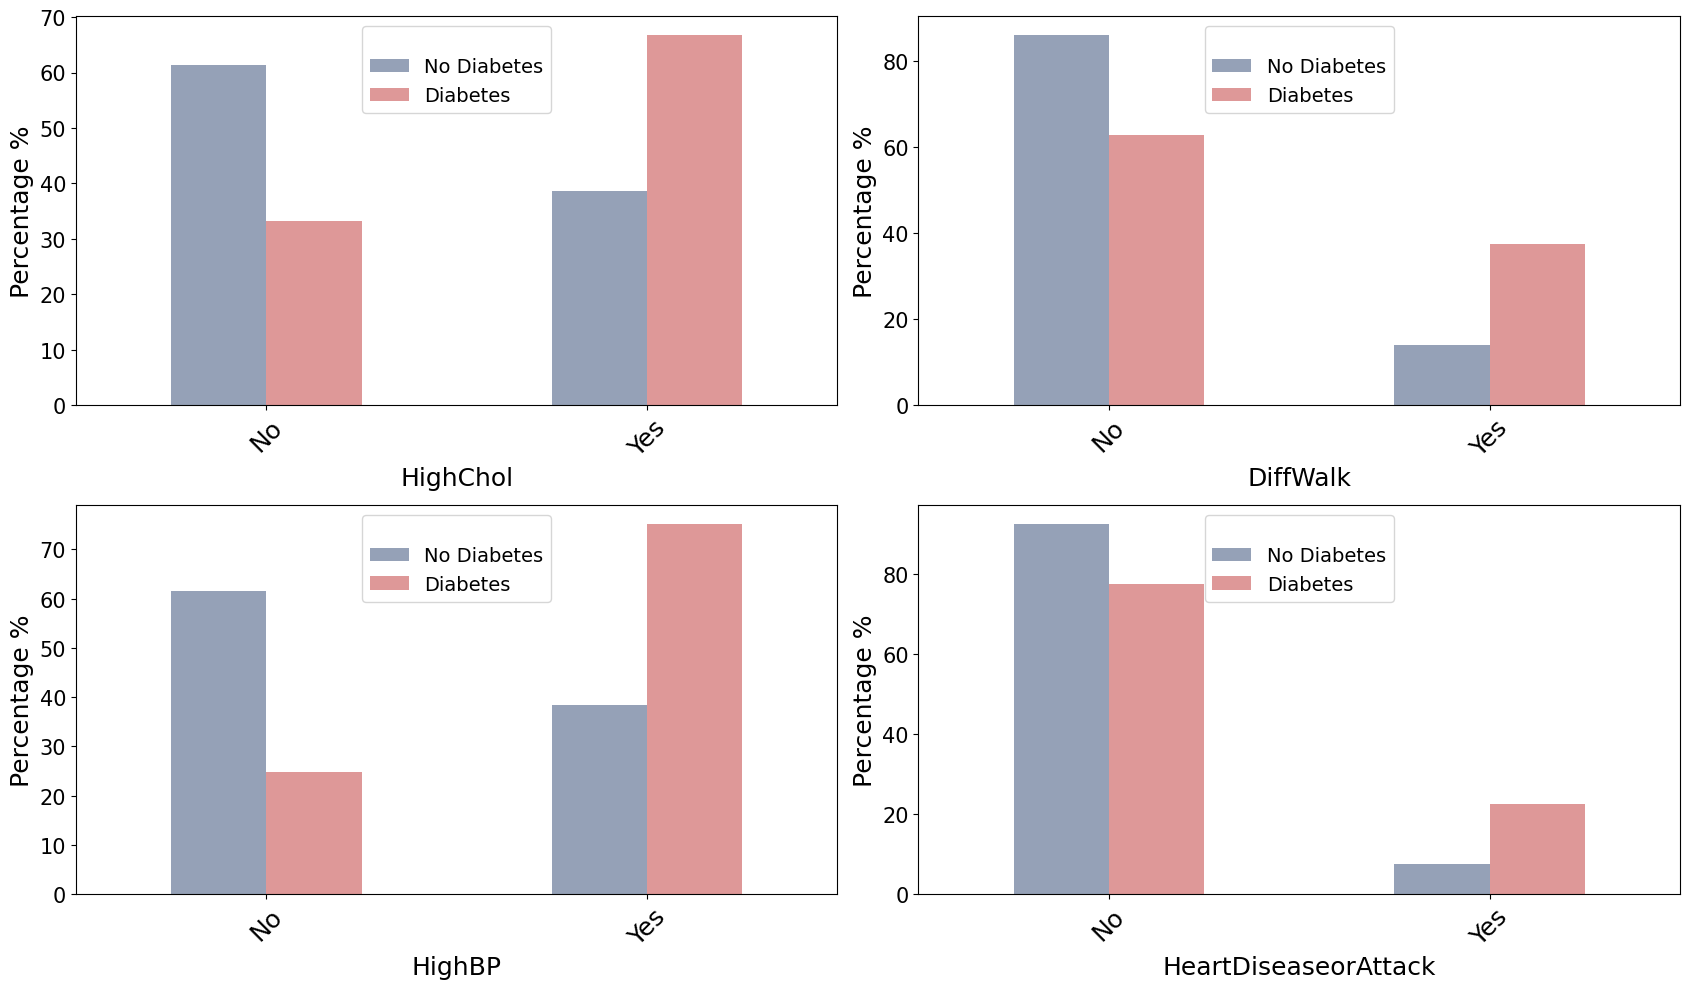

In [161]:
fig, axes = plt.subplots(2, 2, figsize=(17, 10))

for ax, feature in zip(axes.ravel(), binary):

    ct = pd.crosstab(df_train_dropped[feature], Y_train_large )
    ct_normalized = ct.divide(ct.sum(axis=0), axis=1)*100

    ct_normalized.plot(kind='bar', stacked=False, ax=ax, color = ['#2D4471', '#BE3232'],
             alpha = 0.5, fontsize= 15, legend=False  )
    
    ax.set_title('', fontsize=21)
    ax.set_ylabel('Percentage %', fontsize= 18)
    ax.set_xlabel(feature, fontsize= 18)

    ax.set_xticks([0, 1])  
    ax.set_xticklabels(['No', 'Yes'], fontsize=18, rotation=45)
    ax.legend( ['No Diabetes', 'Diabetes'], title=' ', 
               loc='upper center', fontsize = 14)

#for ax in axes.ravel()[len(binary):]:
#    ax.axis('off')

plt.tight_layout()
plt.show()

For Binary (categorical) data we can use the chi squared test to quantify how independent two categorical variables are, i.e. if there is an association between the two variables. This is achieved by this statistical test by comparing the observed frequencies to expected frequencies in a contingency table for the classes.

In [165]:
cts = {}
for feature in binary:
    # Compute the contingency table
    ct = pd.crosstab(df_train_dropped[feature], Y_train_large)    
    cts[feature] = ct 
    # chi-squared test
    _, p_value, _, _ = chi2_contingency(cts[feature])

    # Null hypothesis: There is no association between the two variables
    if (p_value < 0.05):
        print(f"Significant association between diabetes status and {feature}.")

    else:
        print('Failed to reject Null Hypothesis')

Significant association between diabetes status and HighChol.
Significant association between diabetes status and DiffWalk.
Significant association between diabetes status and HighBP.
Significant association between diabetes status and HeartDiseaseorAttack.


The visualization in a bar plot for `HighChol`, `DiffWalk`, `HighBP` demonstrates a tendency to `Diabetes` when the answer is `Yes`. The visual observation is further supported by the chi-squared test. Thus, it can be inferred that Diabetic patients tend to have higher cholesterol, difficulty walking, and higher blood pressure.

On the other hand, while `HeartDiseaseorAttack` seems to have an association with `Diabetes`, this link is less evident in the visual observation.

**Categorical Ordinal**

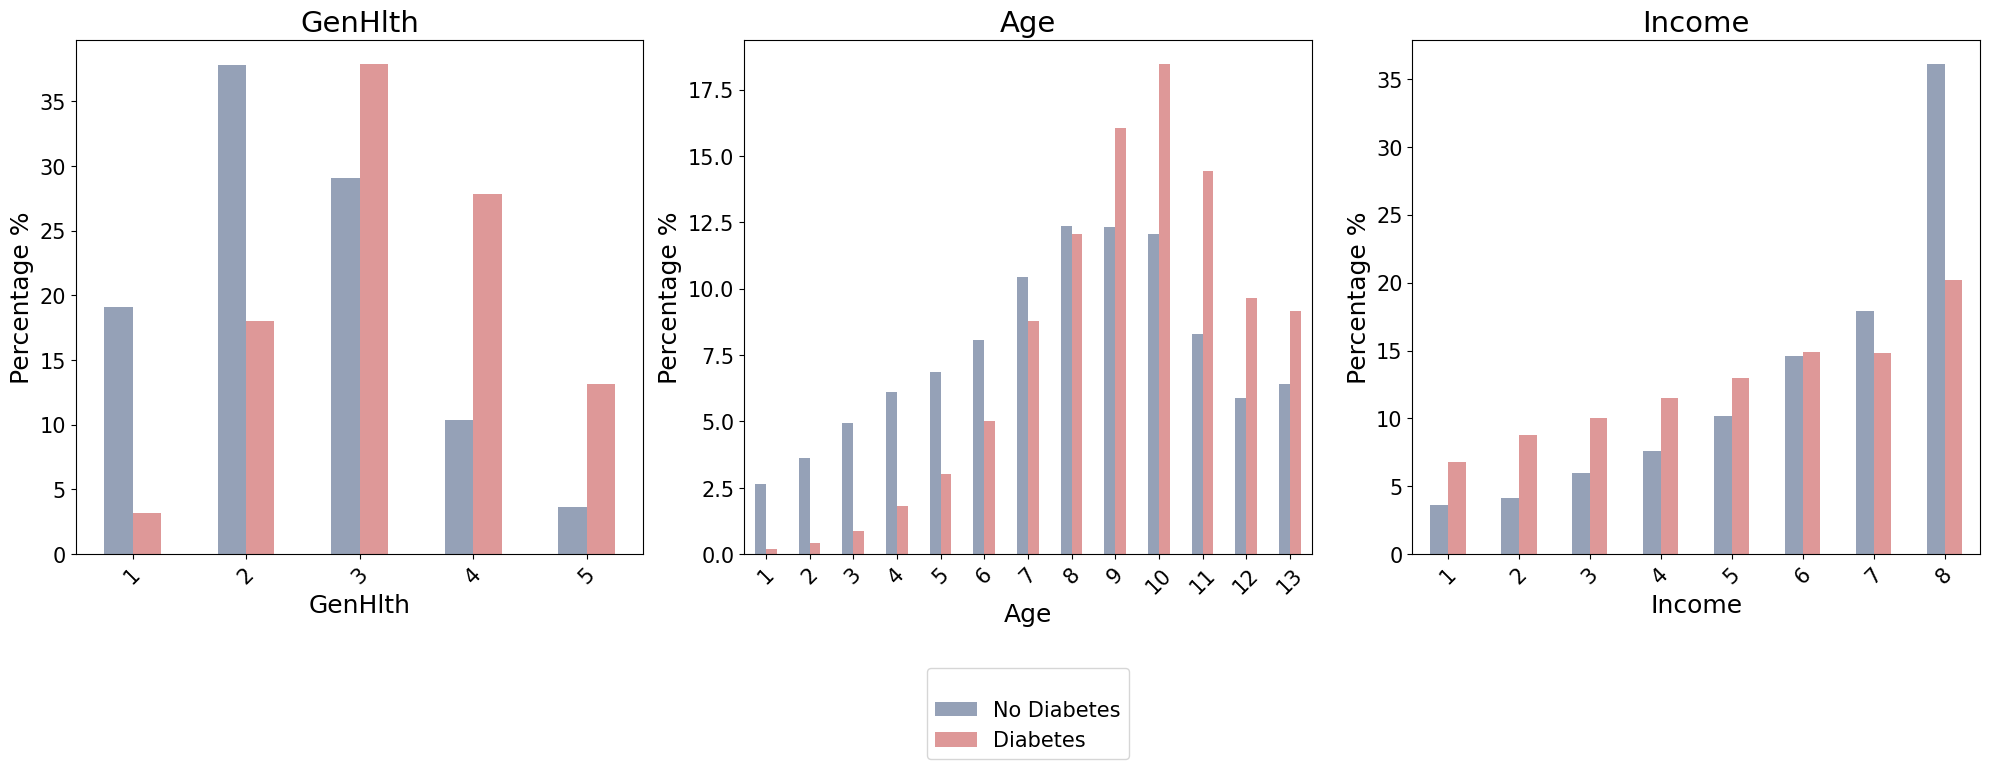

In [108]:
fig, axes = plt.subplots(1, len(categorical), figsize=(20, 8))

for ax, feature in zip(axes.ravel(), categorical):

    ct = pd.crosstab(df_train_dropped[feature], Y_train_large)
    ct_normalized = ct.divide(ct.sum(axis=0), axis=1)*100

    ct_normalized.plot(kind='bar', stacked=False, ax=ax, color=['#2D4471', '#BE3232'], 
            alpha=0.5, fontsize=15, legend=False)

    ax.set_title(feature, fontsize=21)
    ax.set_ylabel('Percentage %', fontsize=18)
    ax.set_xlabel(feature, fontsize=18)

    # Allow x-axis tick labels to take on unique values for non-binary variables
    ax.tick_params(axis='x', rotation=45, labelsize=15)
    
axes[1].legend(['No Diabetes', 'Diabetes'], title=' ', loc='upper center', 
              bbox_to_anchor=(0.5, -0.2), fontsize=15)

#for ax in axes.ravel()[len(non_binary):]:
#    ax.axis('off')

plt.tight_layout()
plt.show()

In [148]:
cts = {}
for feature in categorical:
    # Compute the contingency table
    ct = pd.crosstab(df_train_dropped[feature], Y_train_large)    
    cts[feature] = ct 
    # chi-squared test
    _, p_value, _, _ = chi2_contingency(cts[feature])

    # Null hypothesis: There is no association between the two variables
    if (p_value < 0.05):
        print(f"Significant association between diabetes status and {feature}.")

    else:
        print('Failed to reject Null Hypothesis')

Significant association between diabetes status and GenHlth.
Significant association between diabetes status and Age.
Significant association between diabetes status and Income.


For `GenHlth` it shows a correlation with diabetes. Based on the categories of general health:

1. excellent : less than $5\%$ has diabetes
2. very good : between $15-20 \%$ has diabetes
3. good: more than $35\%$ has diabetes
4. fair: between $25-30 \%$ has diabetes
5. poor: between $10-15 \%$ has diabetes

As general health gets worse, the percentage of individuals diagnosed with diabetes increases. 

For `Age`, there's an observed increment in the percentage of individuals with diabetes as age progresses, though there are some exceptions. This is a good sign, because it is in line with known medical data indicating that the risk of diabetes increases with age.

For `Income` , those individuals with the highest income tend to have an increase in the incidence of diabetes compared to lowest income. But is complex to say more than this, because it does not follow a simple linear trend as for `GenHlth` and `Age`.


**Numerical**

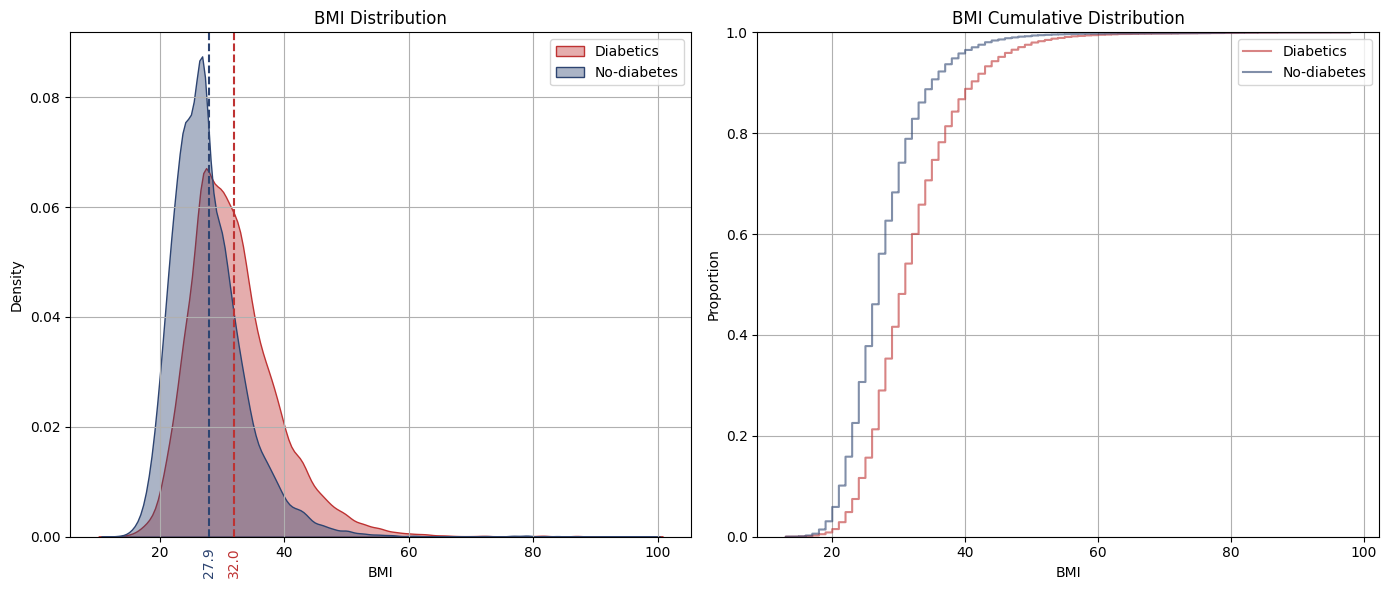

In [88]:
# Divide the dataset into two groups based on Diabetes status
df_train_no = df_train_large[df_train_large['Diabetes'] == 0]
df__train_yes = df_train_large[df_train_large['Diabetes'] == 1]

# Select the BMI feature from each group
df_no_bmi = df_train_no['BMI']
df_yes_bmi = df__train_yes['BMI']


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plotting the distributions
sns.kdeplot(df_yes_bmi, ax=axes[0],color='#BE3232' , alpha=0.4, fill=True)
sns.kdeplot(df_no_bmi, ax=axes[0],color='#2D4471' , alpha=0.4, fill=True)

axes[0].axvline(df_yes_bmi.mean(), color='#BE3232', linestyle='--', alpha = 1)
axes[0].axvline(df_no_bmi.mean(), color='#2D4471', linestyle='--', alpha = 1)

axes[0].text(df_yes_bmi.mean(), -0.007, f'{df_yes_bmi.mean():.1f}',
              color='#BE3232', rotation=90, ha='center')

axes[0].text(df_no_bmi.mean(), -0.007, f'{df_no_bmi.mean():.1f}',
              color='#2D4471', rotation=90, ha='center')



axes[0].grid()
axes[0].set_title('BMI Distribution')
axes[0].legend(['Diabetics', 'No-diabetes'])

# Plotting the CDFs
sns.ecdfplot(df_yes_bmi, ax=axes[1], label="Diabetics", 
             color="#BE3232", alpha=0.6)

sns.ecdfplot(df_no_bmi, ax=axes[1], label="No-diabetes", 
             color="#2D4471", alpha=0.6)

axes[1].grid()
axes[1].set_title('BMI Cumulative Distribution')
axes[1].legend()

plt.tight_layout()
plt.show()


For numerical data, we employ the t-test to compare the means of two groups: BMI for diabetic patients and BMI for non-diabetic patients.  Because the variances of the groups differ, then Welch's t-test is employed, not assuming equal variances. 

In [121]:
print('Diff of Variances:', np.abs(df_yes_bmi.var() - df_no_bmi.var()))
# the variance of the two groups are different, so we use Welch's t-test
_, p_value  = stats.ttest_ind(df_yes_bmi, df_no_bmi, equal_var=False)

# Null hypothesis: The two groups have the same mean
if p_value < 0.05:   
    print('Diabetic and non-diabetic have different BMI')
else:
    print('Failed to reject Null Hypothesis')

Diff of Variances: 16.09348
Diabetic and non-diabetic have different BMI


The distributions and cumulative distribution for BMI in diabetic and non-diabetic patients has a significant difference. The BMI distribution for diabetics appears right-skewed, suggesting a tendency towards higher BMI values compared to the more symmetric distribution of non-diabetics. This difference is more evident in their cumulative distributions, which show a significant gap between the curves. This visual observation is further supported by a Welch's t-test, indicating a significant difference in the mean BMI values of the two groups. Thus, it can be inferred that diabetic patients tend to have higher BMIs than non-diabetics

## **2.3 Conclusion from EDA**

After analyzing the data, we found that the best features for training our machine learning model are:

- HighBP
- GenHlth
- HighChol
- DiffWalk
- Age
- BMI
- HeartDiseaseorAttack
- Income

We saw a clear link between these features and the target variable `Diabetes`. But for the `HeartDiseaseorAttack` and `Income` features, it's harder to say exactly how they relate. All we know is that the relationship isn't linear.

# **3. Model Training**